In [14]:
from anchor import utils
from anchor import anchor_tabular
import pandas as pd
import sklearn.ensemble
import numpy as np
from anchor import anchor_tabular
import os

In [21]:
dataset_folder = '../../../datasets/diabetes/'
target_idx = 8
balance = True
#features_to_use = [0, 1, 2, 3, 4, 5, 6, 7]
features_to_use = [2, 3, 4, 5, 6]
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
dataset = utils.load_csv_dataset(
            os.path.join(dataset_folder, 'diabetes.csv'), target_idx, ',',
            feature_names=feature_names, features_to_use=features_to_use, 
            discretize=True, balance=balance, skip_first=True)
            
print(dataset.train[2])

[0. 1. 3. 0. 3.]


In [22]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
#print(np.unique(dataset.labels_train))
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 0.8785046728971962
Test 0.6481481481481481


In [36]:
transformed_data = []

for r in dataset.train:
    transformed_data.append([dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(r)])        

print(transformed_data[0])

train_data = pd.DataFrame(transformed_data, columns=dataset.feature_names)
print(train_data.shape)
nb_vals = 50

print(dataset.train[0])
print(dataset.train[0].reshape(1, -1))
y=[]
for k in range(0, nb_vals):
    y.append(c.predict(dataset.train[k].reshape(1, -1))[0])


['BloodPressure <= 62.00', '0.00 < SkinThickness <= 23.00', '30.50 < Insulin <= 127.25', 'BMI <= 27.30', '0.37 < DiabetesPedigreeFunction <= 0.63']
(428, 5)
[0. 1. 2. 0. 2.]
[[0. 1. 2. 0. 2.]]


In [37]:
import sys
sys.path.append(sys.path[0] + '/../..')

import arg_explainer as ae
from importlib import reload
reload(ae)
import arg_explainer as ae

print(dataset.feature_names)
explainer = ae.ArgTabularExplainer(c, train_data.iloc[0:nb_vals], y, 'diabetesshort_' + str(nb_vals), compute=True, output_path='../../saves')
print(explainer.features_p_col)

['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
Generating arguments
len  1 : 0 ,  0
19 potential arg checked ( 0 not minimal)
len  2 : 22 ,  38
137 potential arg checked ( 0 not minimal)
len  3 : 29 ,  19
88 potential arg checked ( 210 not minimal)
len  4 : 0 ,  0
5 potential arg checked ( 191 not minimal)
len  5 : 0 ,  0
0 potential arg checked ( 43 not minimal)
Saving to  ../../saves\diabetesshort_50_minimals.df
{'BloodPressure': {0, 1, 2, 3}, 'SkinThickness': {4, 5, 6, 7}, 'Insulin': {8, 9, 10}, 'BMI': {11, 12, 13, 14}, 'DiabetesPedigreeFunction': {16, 17, 18, 15}}


In [38]:
G = explainer.build_attack_graph(compute=True, display_graph=False)
print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))

explainer.export_graph('asp', '../../saves')
print(len(G.nodes()))

diabetesshort_50
edges per node: 14.61111111111111
108


[211460, 154450, 2303352, 114713, 82090, 54653, 31453, 14048, 0, 546608, 1488040, 913479, 1080708, 1392633, 772173, 37634, 554489, 411603, 316629, 250699, 197328]
(50, 100, 200, 300, 400, 10752, 21504, 32256, 43008, 53760, 64512, 75264, 86016, 96768, 107520, 118272, 129024, 139776, 150528, 161280, 172032) (435, 1048, 1729, 2258, 2800, 37542, 47303, 51001, 51122, 50106, 49368, 48795, 47572, 45844, 43529, 40607, 37520, 34229, 30720, 27759, 24846)


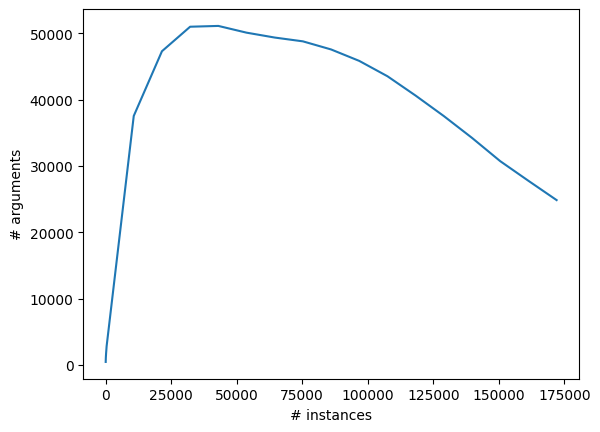

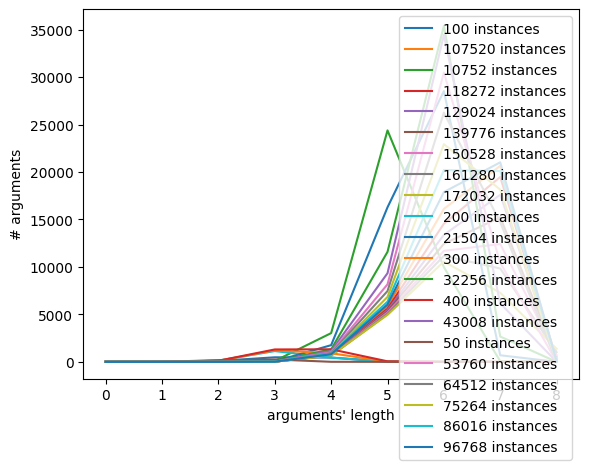

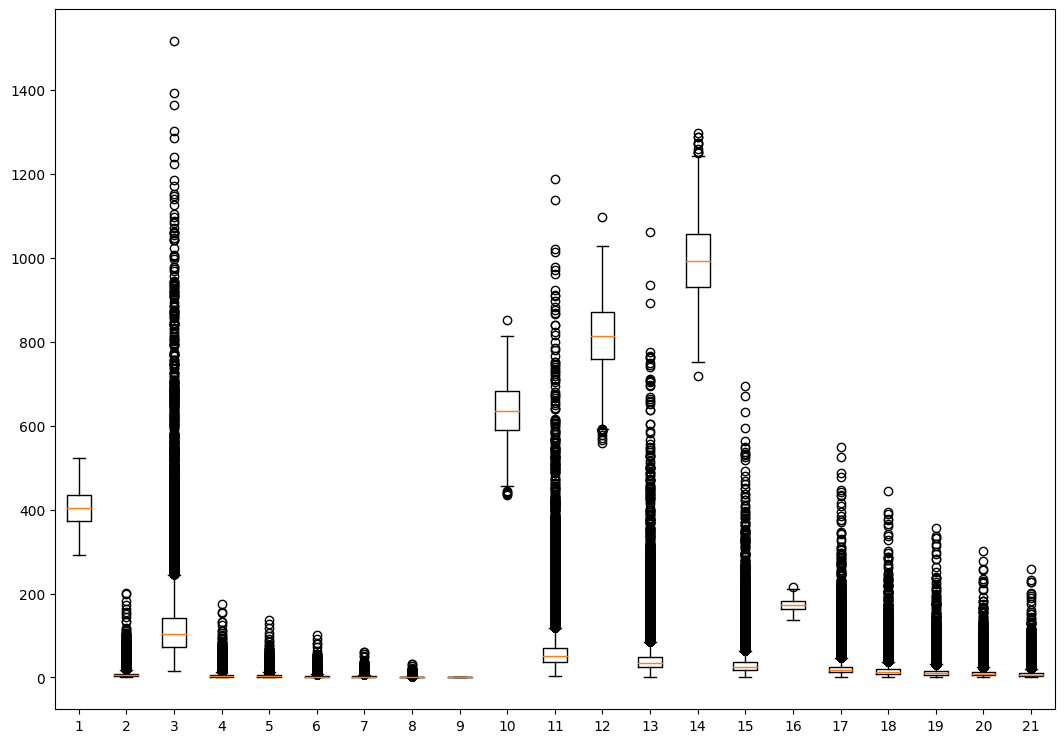

(172032, 161280, 150528, 139776, 129024, 118272, 107520, 96768, 86016, 75264, 64512, 53760, 43008, 32256, 21504, 10752, 400, 300, 200, 100, 50) (1.0, 0.6035880255052415, 0.3759765625, 0.2251891670805457, 0.13179637526652455, 0.07644002265619232, 0.04116795699418774, 0.02128959078614434, 0.010089968889262613, 0.004570140383235999, 0.0018635553394911186, 0.00039915379395683015, 9.780525018587838e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


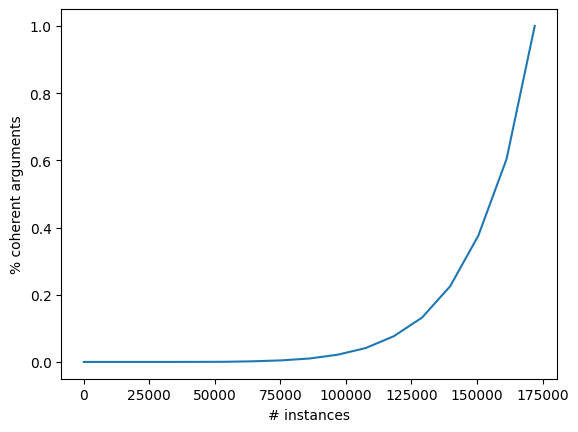

In [15]:
explainer.af_analysis()

In [8]:
from typing import OrderedDict
import networkx as nx
from sklearn import preprocessing
import random

le = preprocessing.LabelEncoder()
#print(explainer.categorical_names)
#print(explainer.categorical_features)
#print(explainer.ordinal_features)
#le.set_params(explainer.feature_names)

def generate_full_dataset():
    instance = OrderedDict.fromkeys(explainer.dataset.columns)
    full_dataset = []
    def gen_rec(instance, columns, col_index, full_dataset):
        inst_ = instance.copy()
        if col_index == len(columns) - 1:
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                full_dataset.append(list(inst_.values()))
        else:
            inst_ = instance.copy()
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                gen_rec(inst_, columns, col_index + 1, full_dataset)

    gen_rec(instance, list(instance.keys()), 0, full_dataset)
    return full_dataset

def generate_instance_random(constraints):
    instance = OrderedDict.fromkeys(explainer.dataset.columns)
    for f in constraints:
        col=explainer.col_p_feature[f]
        instance[col] = explainer.feature_names[f].split('_')[1]
        fill_instance(instance, 'random')
    return list(instance.values())

def fill_instance(instance, strategy):
    if strategy == 'random':
        # fill the instance with a random values sampled from baseline dataset
        for i_, col in enumerate(instance.keys()):
            if instance[col] is None:
                instance[col] = explainer.dataset[col].sample(1, random_state=1).values[0]
    elif strategy == 'most_frequent':
        # fill the instance with the most frequent value for each column
        for k, i_ in enumerate(instance.keys()):
            if instance[k] is None:
                instance[k] = explainer.dataset[i_].value_counts().index[0]
    
def instance2encoded(instance, dataset):
    encoded = []
    for col in dataset.categorical_features:
        encoded.append(dataset.categorical_names[col].index(instance[col]))
    return np.array(encoded)

def extend_dataset(G, dataset_t, y_t):
    # attackers = []
    # print(G.degree)
    # for v, deg in G.degree:
    #     if deg > 0:
    #         attackers += G.edges(v)
    # print('len attackers:', len(attackers))
    # print(attackers[0])
    # # predict new data
    # transformed_data_plus = []
    # y_plus = []
    # print("Generating " + str(len(attackers)) + " new data...")
    # addition_set = set([tuple(i) for i in dataset_t])
    # for a in attackers:
    #     # print(a, [explainer.feature_names[k] for k in a[1]])
    #     inst = generate_instance_random(set.union(set(a[0]), set(a[1])))
    #     if tuple(inst) not in addition_set:
    #         addition_set.add(tuple(inst))
    #         transformed_data_plus.append(inst)
    #         y_plus.append(c.predict(instance2encoded(inst, dataset).reshape(1, -1))[0])
    # print(str(len(transformed_data_plus)) + " instances added")
    # print(str(len(y_plus)) + " instances predicted")

    full_dataset = generate_full_dataset()
    transformed_data_plus = full_dataset
    encoded_data_plus = [c.predict(instance2encoded(i_, dataset).reshape(1,-1))[0] for i_ in full_dataset]
    y_plus = encoded_data_plus
    train_data_plus = train_data = pd.DataFrame(transformed_data[:nb_vals] + transformed_data_plus, columns=dataset.feature_names)
    
    dataset_t += transformed_data_plus
    y_t += y_plus
    print('total length', len(dataset_t), len(y_t))
    train_data_plus = pd.DataFrame(dataset_t, columns=dataset.feature_names)
    #print(train_data_plus.shape)
    #print(y_plus)
    explainer = ae.ArgTabularExplainer(c, train_data_plus, y_t, 'diabetes_' + str(nb_vals) + '_extended', compute=True, output_path='../../saves')

    G = explainer.build_attack_graph(compute=True, display_graph=True)
    print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))
    return G, dataset_t, y_t

def explore_full_dataset(nb_steps):
    full_dataset = generate_full_dataset()
    y_plus = [c.predict(instance2encoded(i_, dataset).reshape(1,-1))[0] for i_ in full_dataset]
    #train_data_plus = train_data = pd.DataFrame(transformed_data[:nb_vals] + transformed_data_plus, columns=dataset.feature_names)
    
    random.seed(1)
    indices = list(range(len(full_dataset)))
    random.shuffle(indices)
    full_dataset_shuff = [full_dataset[i] for i in indices] 
    y_plus_shuff = [y_plus[i] for i in indices]

    print(np.unique(np.array(y_plus_shuff)))
    print('len full', len(full_dataset_shuff))
    step_len = len(full_dataset)//nb_steps
    steps = [i*step_len for i in range(5, nb_steps)]
    steps.append(len(full_dataset))
    for nb_vals in steps:
        dataset_t = full_dataset_shuff[:nb_vals]
        y_t = y_plus_shuff[:nb_vals]
        print('total length', len(dataset_t), len(y_t))
        train_data_plus = pd.DataFrame(dataset_t, columns=dataset.feature_names)

        explainer = ae.ArgTabularExplainer(c, train_data_plus, y_t, 'diabetes_' + str(nb_vals) + '_synth', compute=True, output_path='../../saves')

        G = explainer.build_attack_graph(compute=True, display_graph=False)
        print('total args:', len(G.nodes()))
        print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))

# dataset_t = transformed_data[:nb_vals]
# y_t = y[:nb_vals]
# # dataset_t = []
# # y_t = []
# for k in range(0, 1):
#     print('iteration', k)
#     G, dataset_t, y_t = extend_dataset(G, dataset_t, y_t)
#     print('uniques', len(set([tuple(i) for i in dataset_t])))

explore_full_dataset(16)

[0 1]
len full 172032
total length 53760 53760
Generating arguments
len  1 : 0 ,  0
41 potential arg checked ( 0 not minimal)
len  2 : 0 ,  0
690 potential arg checked ( 0 not minimal)
len  3 : 32 ,  0
6368 potential arg checked ( 0 not minimal)
len  4 : 880 ,  116
35015 potential arg checked ( 665 not minimal)
len  5 : 5117 ,  3049
109163 potential arg checked ( 16021 not minimal)
len  6 : 15108 ,  15361
155353 potential arg checked ( 113182 not minimal)
len  7 : 4072 ,  6370
37627 potential arg checked ( 213845 not minimal)
len  8 : 0 ,  1
1 potential arg checked ( 53759 not minimal)
Saving to  ../saves\diabetes_53760_synth_minimals.df
diabetes_53760_synth
total args: 50106
edges per node: 22.132638805731847
total length 64512 64512
Generating arguments
len  1 : 0 ,  0
41 potential arg checked ( 0 not minimal)
len  2 : 0 ,  0
690 potential arg checked ( 0 not minimal)
len  3 : 28 ,  0
6368 potential arg checked ( 0 not minimal)
len  4 : 828 ,  95
35097 potential arg checked ( 583 not

In [ ]:
explainer.af_analysis(remove=['adult_'])

In [40]:
#ext_gen = explainer.extension_generator_from_graph()
ext_gen = explainer.extension_generator_from_sat(file='../../saves/diabetesshort_50_sat.txt')
#max_covi_ext = explainer.make_selection('max_covi_incl', ext_gen)
max_covi_ext = explainer.make_selection('max_card', ext_gen)
res = explainer.apply_inference(max_covi_ext, 'universal')
#print(res)

explainer.display_explanations(verbose=True)

Using pre-processed file...
Reading ../../saves/diabetesshort_50_sat_preprocessed.txt
Time for selection:  54.090741872787476
Len max_cov_exts:  1
id: 0 coverage: 0 Arg 1/0: None
id: 1 coverage: 0 Arg 1/0: None
id: 2 coverage: 9 Arg 1/5: frozenset({'DiabetesPedigreeFunction_DiabetesPedigreeFunction > 0.63', 'BMI_BMI <= 27.30'})
id: 3 coverage: 9 Arg 1/4: frozenset({'SkinThickness_SkinThickness > 32.00', 'Insulin_Insulin > 127.25'})
id: 4 coverage: 13 Arg 1/5: frozenset({'SkinThickness_SkinThickness > 32.00', 'Insulin_Insulin > 127.25'})
id: 5 coverage: 8 Arg 1/5: frozenset({'BMI_BMI > 36.60', 'Insulin_Insulin <= 0.00'})
id: 6 coverage: 0 Arg 1/0: None
id: 7 coverage: 10 Arg 1/5: frozenset({'SkinThickness_SkinThickness > 32.00', 'Insulin_Insulin > 127.25'})
id: 8 coverage: 0 Arg 1/0: None
id: 9 coverage: 0 Arg 1/0: None
id: 10 coverage: 5 Arg 1/4: frozenset({'SkinThickness_SkinThickness <= 0.00', 'DiabetesPedigreeFunction_0.24 < DiabetesPedigreeFunction <= 0.37'})
id: 11 coverage: 0 Arg

In [7]:
ext_gen = explainer.extension_generator_from_graph()
#ext_gen = explainer.extension_generator_from_sat(file='../saves/diabetes_100_sat.txt')
max_covi_ext = explainer.make_selection('max_covi', ext_gen)

Working with NetworkX to find naive extensions:
Graph density =  0.3986863711001642


KeyboardInterrupt: 

In [56]:
#sel = explainer.make_selection(max_covi_ext, 'max_covc')
res = explainer.apply_inference(max_covi_ext, 'universal')
#print(res)

explainer.display_explanations()


{frozenset({33}), frozenset({23}), frozenset({32, 43}), frozenset({34}), frozenset({27}), frozenset({32, 3}), frozenset({32, 6}), frozenset({24}), frozenset({26}), frozenset({32, 14}), frozenset({28}), frozenset({29}), frozenset({30}), frozenset({32, 18}), frozenset({32, 1}), frozenset({32, 52})}
id: 0 coverage: 2 Arg 1/2: frozenset({'Education_Some-college', 'Occupation_Sales'})
id: 1 coverage: 0 Arg 1/0: None
id: 2 coverage: 0 Arg 1/0: None
id: 3 coverage: 2 Arg 1/1: frozenset({'Occupation_Machine-op-inspct'})
id: 4 coverage: 0 Arg 1/0: None
id: 5 coverage: 2 Arg 1/1: frozenset({'Occupation_Farming-fishing'})
id: 6 coverage: 0 Arg 1/0: None
id: 7 coverage: 2 Arg 1/3: frozenset({'Occupation_Sales', 'Sex_Female'})
id: 8 coverage: 0 Arg 1/0: None
id: 9 coverage: 3 Arg 1/1: frozenset({'Occupation_Prof-specialty'})
id: 10 coverage: 0 Arg 1/0: None
id: 11 coverage: 1 Arg 1/1: frozenset({'Occupation_Transport-moving'})
id: 12 coverage: 0 Arg 1/0: None
id: 13 coverage: 1 Arg 1/1: frozenset({

## Sat solver: ASPARTIX

In [ ]:
ext_gen = explainer.extension_generator(file='asp_test.txt')
max_covi_ext = explainer.make_selection(ext_gen, 'max_covi')

In [ ]:
explainer.set_strategy('max_covc', 'existence')
## Define strategy before calling explainer.explain()
explainer.display_explanations()

0.4019384124647283
Number of extensions: 1326480
Time spent on naive extensions: 55.99906277656555 s ( 86.23851943016052 )
len(max_cov_exts)= 1326478 / 1326480
Covc strategy's coverage: 2
Top 5 covs: [2, 2, 2, 2, 2]
id: 0 coverage: 1 Arg 1/12: frozenset({'Relationship_Husband', 'Country_United-States', 'Education_Some-college'})
id: 1 coverage: 1 Arg 1/10: frozenset({'Marital Status_Never-married', 'Age_37.00 < Age <= 48.00'})
id: 2 coverage: 1 Arg 1/22: frozenset({'Age_Age > 48.00', 'Occupation_Exec-managerial', 'Capital Gain_0', 'Workclass_Private'})
id: 3 coverage: 1 Arg 1/18: frozenset({'Hours per week_Hours per week <= 40.00', 'Occupation_Machine-op-inspct'})
id: 4 coverage: 1 Arg 1/17: frozenset({'Capital Loss_0', 'Capital Gain_0', 'Occupation_Sales', 'Hours per week_Hours per week <= 40.00', 'Relationship_Husband'})
id: 5 coverage: 1 Arg 1/8: frozenset({'Occupation_Farming-fishing', 'Hours per week_Hours per week <= 40.00'})
id: 6 coverage: 1 Arg 1/24: frozenset({'Education_Bach

In [ ]:
explainer.set_strategy('max_covc', 'universal')
## Define strategy before calling explainer.explain()
explainer.display_explanations()

0.40616693248272195
Number of extensions: 521076
len(max_cov_exts)= 521074 / 521076
Covc strategy's coverage: 2
Top 5 covs: [2, 2, 2, 2, 2]
id: 0 coverage: 0 Arg 1/0: None
id: 1 coverage: 0 Arg 1/0: None
id: 2 coverage: 0 Arg 1/0: None
id: 3 coverage: 0 Arg 1/0: None
id: 4 coverage: 0 Arg 1/0: None
id: 5 coverage: 0 Arg 1/0: None
id: 6 coverage: 0 Arg 1/0: None
id: 7 coverage: 0 Arg 1/0: None
id: 8 coverage: 0 Arg 1/0: None
id: 9 coverage: 0 Arg 1/0: None
id: 10 coverage: 0 Arg 1/0: None
id: 11 coverage: 0 Arg 1/0: None
id: 12 coverage: 0 Arg 1/0: None
id: 13 coverage: 0 Arg 1/0: None
id: 14 coverage: 0 Arg 1/0: None
id: 15 coverage: 0 Arg 1/0: None
id: 16 coverage: 0 Arg 1/0: None
id: 17 coverage: 0 Arg 1/0: None
id: 18 coverage: 0 Arg 1/0: None
id: 19 coverage: 0 Arg 1/0: None
id: 20 coverage: 0 Arg 1/0: None
id: 21 coverage: 0 Arg 1/0: None
id: 22 coverage: 0 Arg 1/0: None
id: 23 coverage: 0 Arg 1/0: None
id: 24 coverage: 0 Arg 1/0: None
id: 25 coverage: 0 Arg 1/0: None
id: 26 cover

In [ ]:
explainer.set_strategy('max_covi', 'universal')
## Define strategy before calling explainer.explain()
explainer.display_explanations()

0.40616693248272195
Number of extensions: 521076
len(max_cov_exts)= 12 / 521076
Covi strategy's coverage: 60
Top 5 covs: [58, 58, 58, 58, 58]
id: 0 coverage: 0 Arg 1/0: None
id: 1 coverage: 5 Arg 1/4: frozenset({'Relationship_Not-in-family', 'Occupation_Exec-managerial'})
id: 2 coverage: 0 Arg 1/0: None
id: 3 coverage: 3 Arg 1/1: frozenset({'Occupation_Machine-op-inspct', 'Age_28.00 < Age <= 37.00'})
id: 4 coverage: 0 Arg 1/0: None
id: 5 coverage: 2 Arg 1/1: frozenset({'Occupation_Farming-fishing', 'Age_28.00 < Age <= 37.00'})
id: 6 coverage: 2 Arg 1/1: frozenset({'Sex_Female', 'Occupation_Protective-serv'})
id: 7 coverage: 3 Arg 1/1: frozenset({'Occupation_Sales', 'Education_Bachelors'})
id: 8 coverage: 2 Arg 1/1: frozenset({'Occupation_?', 'Sex_Male'})
id: 9 coverage: 3 Arg 1/2: frozenset({'Occupation_Prof-specialty', 'Education_Bachelors', 'Workclass_Private'})
id: 10 coverage: 4 Arg 1/1: frozenset({'Occupation_Protective-serv', 'Sex_Male'})
id: 11 coverage: 1 Arg 1/1: frozenset({'A

In [ ]:
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    dataset.class_names,
    dataset.feature_names,
    dataset.train,
    dataset.categorical_names)
idx = 0
np.random.seed(1)
instance = dataset.train[idx].reshape(1, -1)[0]
print("Anchor")
print([dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(instance)])

print('Prediction: ', anchor_explainer.class_names[c.predict(dataset.train[0].reshape(1, -1))[0]])
exp = anchor_explainer.explain_instance(dataset.train[idx], c.predict, threshold=0.95)
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

print("Arg:", idx)
print(explainer.explain_instance(idx))

Anchor
['Age > 48.00', 'Self-emp-not-inc', 'Some-college', 'Married-civ-spouse', 'Sales', 'Husband', 'White', 'Male', '2', '0', '40.00 < Hours per week <= 45.00', 'United-States']
Prediction:  b'>50K'
Anchor: Capital Gain = 2
Precision: 1.00
Coverage: 0.07
Arg: 0
id: 0 coverage: 10 Args5/5: {frozenset({'Occupation_Sales', 'Age_Age > 48.00'}), frozenset({'Workclass_Self-emp-not-inc', 'Age_Age > 48.00'}), frozenset({'Workclass_Self-emp-not-inc', 'Occupation_Sales'}), frozenset({'Education_Some-college', 'Workclass_Self-emp-not-inc'}), frozenset({'Education_Some-college', 'Occupation_Sales', 'Country_United-States'})}
None
